## Feature Selection Methods

Given that the T2D dataset has more features than samples (2750 features vs ~2100 samples), there aren't enough degrees of freedom to reliably train a machine learning model. Most of the classifiers trained on the existing dataset max out at ~0.67 ROC AUC. Possible feature selection approaches are detailed below. This notebook explores the efficacy of various feature selection techniques and stores new training datasets to test model performance on under src/data/T2D_data/.

In [34]:
import pandas as pd
import numpy as np
import os
import sys
import boto3
import s3fs
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from itertools import compress
import matplotlib.pyplot as plt
import jupyterthemes
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from auth import access_key, secret_key
from Evaluator import Evaluator

In [35]:
# Alter with lipids/t2d/other if needed
options = ["t2d", "lipids", "grouped"]
trait = options[2]

train_filepath = "S3://voightlab-data/{}/{}_train.csv".format(trait, trait)
test_filepath = "S3://voightlab-data/{}/{}_test.csv".format(trait, trait)

# Used to name the output files
outpath = "voightlab-data/{}/FeatureSelected/".format(trait)

In [36]:
train_df = pd.read_csv(train_filepath, index_col=0)
test_df = pd.read_csv(test_filepath, index_col=0)
train_df.head()

,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,...,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount,is_t2d,is_lipids,is_both,label
1804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,1,0,0,1
8603,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0.002347,0,1,0,2
9643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.002347,0,0,0,0
5414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.001173,0,0,0,0
9989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,1,1,0,3


In [37]:
# Create training and test splits, dropping labels and sample weights from training set
labels = ['label']
to_drop = ['is_t2d', 'is_lipids', 'is_both']

X_train = train_df.drop(labels + to_drop, axis=1)
y_train = train_df.loc[:, labels]

X_test = test_df.drop(labels + to_drop, axis=1)
y_test = test_df.loc[:, labels]

In [38]:
# Create combined dataset case we want to run feature selection tests on the entire combined dataset
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [39]:
X_test.head()

,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,...,Hepatocyte_PPARA_GW7647_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,liver_USF1_ctrl_peaks.narrowPeak,liver_USF1_ASH_peaks.narrowPeak,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount
2812,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000587
1702,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0.024934
3572,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.001760
8296,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0.010560
8194,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0.001760


In [40]:
# Init object for visualization and evaluation
ev = Evaluator()

In [41]:
# For storage once we have done the feature selection
def write_to_S3(df, filename):
    bytes_to_write = df.to_csv(None).encode()
    fs = s3fs.S3FileSystem(key=access_key, secret=secret_key)
    with fs.open(outpath + filename, 'wb') as f:
        f.write(bytes_to_write)

### Variance Threshold

VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples. This method only looks at the features, not the labels. This means that it can be used in unsupervised learning, however it is not accounting for any particular distinctions between the controls and positives. 

In a dataset with boolean features we can remove all features that are either one or zero in more than a certain % of the samples. We can further prune the feature set by taking only the top n features in terms of displaying the most variance.

Since boolean variables are Bernoulli random variables, their variance is given by p(1-p). So as an example, if we want to remove all features that are either one or zero (on or off) in more than 80% of the samples then we woould set the threshold parameter of the selector to = .80 * (1 - 0.80).

A note on this approach in this instance is that it might not be particularly effective for such an imbalanced dataset, as features displaying the most variation could display that variation all within the larger control class. 

In [42]:
selector = VarianceThreshold(threshold=.70 * (1 - .70))
selector.fit_transform(X_train, y_train)

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [43]:
print ("Samples remaining in the featureset: {}".format(len(selector.variances_)))

Samples remaining in the featureset: 2748


Here we set n to some number, representing the number of features that we want to keep. We obtain the indices of elements with the highest variance and create a new dataframe for training containing only those features.

In [44]:
# Select the top n features, where features are ranked based on how much variance they display
n = 150
top_idx = np.argsort(selector.variances_)[-n:]
vt_features = [selector.variances_[i] for i in top_idx]
vt_traindf = X_train.iloc[:, top_idx]
vt_testdf = X_test.iloc[:, top_idx]

In [45]:
vt_traindf.head()

,epithelial_cell_of_proximal_tubule_transcription_profiling_by_array_assay_ENCSR000CZF_ENCFF001VYA_ENCFF001VXZ_intersect.bed,cardiac_mesoderm_transcription_profiling_by_array_assay_ENCSR000CYE_ENCFF001VTD_ENCFF001VTC_intersect.bed,NT2-D1_transcription_profiling_by_array_assay_ENCSR000CYP_ENCFF001VXT_ENCFF001VXU_intersect.bed,WI38_transcription_profiling_by_array_assay_ENCSR000CZE_ENCFF001VYN_ENCFF001VYO_intersect.bed,WI38_transcription_profiling_by_array_assay_ENCSR000CZD_ENCFF001VYM_ENCFF001VYL_intersect.bed,smooth_muscle_cell_of_the_brain_vasculature_transcription_profiling_by_array_assay_ENCSR000CYV_ENCFF001VTR_ENCFF001VTS_intersect.bed,GM12864_transcription_profiling_by_array_assay_ENCFF001VSS.bed,astrocyte_of_the_cerebellum_transcription_profiling_by_array_assay_ENCSR000CZC_ENCFF001VTG_ENCFF001VTH_intersect.bed,SK-N-MC_transcription_profiling_by_array_assay_ENCSR000CYN_ENCFF001VYF_ENCFF001VYG_intersect.bed,astrocyte_of_the_spinal_cord_transcription_profiling_by_array_assay_ENCSR000CZI_ENCFF001VTN_ENCFF001VTM_intersect.bed,...,K562_ChIP-seq_CHD7_ENCFF001SYZ.bed,E121-H3K27me3.gappedPeak,E005-H2BK120ac.gappedPeak,K562_transcription_profiling_by_array_assay_ENCFF001SNY.bed,E076-H3K4me1.gappedPeak,E005-H3K9me3.gappedPeak,K562_ChIP-seq_KAT2B_ENCFF001SZW.bed,E080-H3K27me3.gappedPeak,HepG2_transcription_profiling_by_array_assay_ENCFF001SNP.bed,K562_ChIP-seq_CBX3_ENCFF001SYW.bed
1804,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,1
8603,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,1,1,0,1,1
9643,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
5414,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,1,0,1
9989,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,1


In [46]:
# Write the created dataset to a file so we can test model performance later
write_to_S3(vt_traindf, "var_threshold/X_train.csv")
write_to_S3(y_train, "var_threshold/y_train.csv")
write_to_S3(vt_testdf, "var_threshold/X_test.csv")
write_to_S3(y_test, "var_threshold/y_test.csv")

### Univariate Feature Selection

The sklearn GenericUnivariateSelect allows to perform univariate feature selection with a configurable strategy. This allows us to select the best univariate selection strategy with a hyper-parameter search estimator, similar to grid search. Here I've compared the association of the features to a target variable using a chi square test and sklearn's mutual info classificaion test. 

First we set the scoring parameter of the class to the chi2 test, selecting the n best performing features, i.e, the features with the n highest values for the test chi-squared statistic. Here, we are measuring whether each categorical feature is independent of the target class. We assume a null hypothesis that the frequencies of each variable is similarly distributed to the features of the classes. If we cannot reject the null hypothesis for a variable, we dispose of that feature. 

It should be noted that the sklearn implementation of the chi squared test only considers features where x=1. I.e, it looks at features where x=1 and sees if the distribution of values for y matches that of the overall population.

In [47]:
# Return n best features based on the test
n = 25
chi_gus = GenericUnivariateSelect(chi2, mode='k_best', param=n)
chi_gus.fit(X_train, y_train)

GenericUnivariateSelect(mode='k_best', param=25,
            score_func=<function chi2 at 0x1a1b0630d0>)

In [48]:
# Save features using the boolean mask 
chi_idx = chi_gus.get_support()
chi_features = list(compress(X_train, chi_idx)) 
chi_pvalues = list(compress(chi_gus.pvalues_, chi_idx))

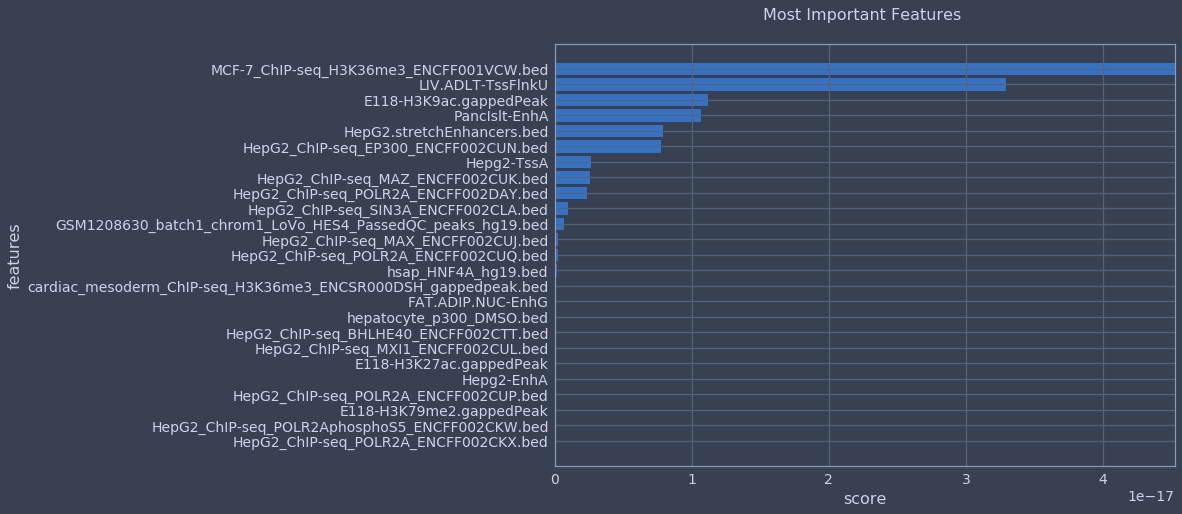

In [49]:
# Visualize p values for each feature from test
important_features = ev.feat_importance(chi_pvalues, chi_features, n=len(chi_features))

Now we try again using the mutual info classification test. Mutual information for each feature x and y is a measure of their mutual dependence. More generally, it determines how similar the joint distribution p(x, y) is to the products of factored marginal distribution p(x) * p(y). Mutual information is the expected value of the pointwise mutual information.   

In [50]:
mic_gus = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=n)
mic_gus.fit(X_train, y_train)

/Users/kaushikvisvanathan/anaconda/envs/t2d_model/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GenericUnivariateSelect(mode='k_best', param=25,
            score_func=<function mutual_info_classif at 0x1a1b2d4ae8>)

In [51]:
# Save features using the boolean mask 
mic_idx = mic_gus.get_support()
mic_features = list(compress(X_train.columns, mic_idx)) 
mic_scores = list(compress(mic_gus.scores_, mic_idx))

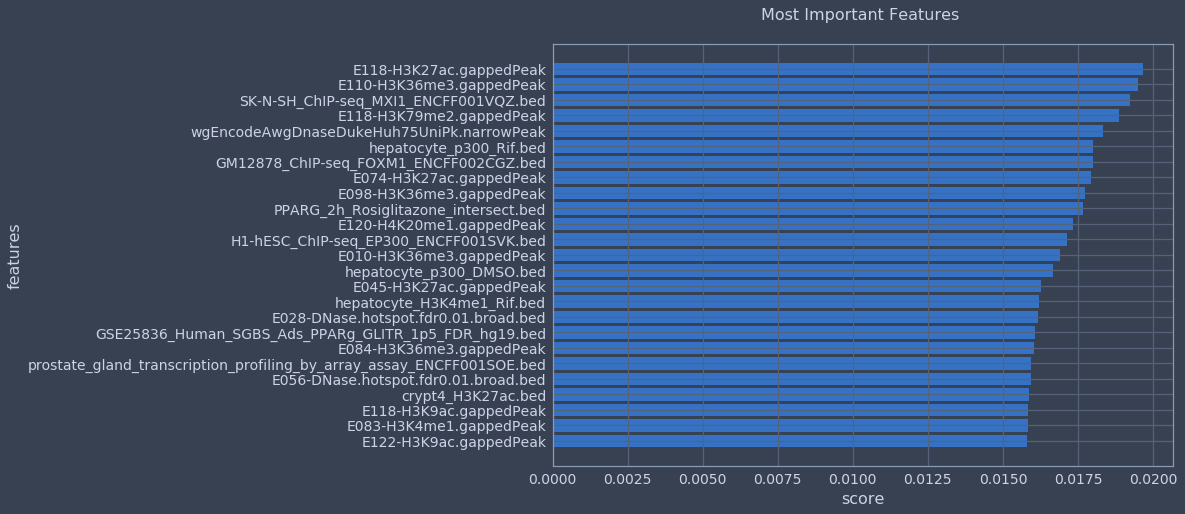

In [52]:
# Visualize scores for each feature from test
important_features = ev.feat_importance(mic_scores, mic_features, n=len(mic_features))

In [53]:
# Save training and testing datframes only consisting of the features we have selected
chi_Xtraindf = X_train.iloc[:, chi_idx]
chi_Xtestdf = X_test.iloc[:, chi_idx]

# Write the created dataset to a file so we can test model performance later
write_to_S3(chi_Xtraindf, "chi2/X_train.csv")
write_to_S3(y_train, "chi2/y_train.csv")
write_to_S3(chi_Xtestdf, "chi2/X_test.csv")
write_to_S3(y_test, "chi2/y_test.csv")

In [54]:
# Save training and testing datframes only consisting of the features we have selected
mic_Xtraindf = X_train.iloc[:, mic_idx]
mic_Xtestdf = X_test.iloc[:, mic_idx]

# Write the created dataset to a file so we can test model performance later
write_to_S3(mic_Xtraindf, "mic/X_train.csv")
write_to_S3(y_train, "mic/y_train.csv")
write_to_S3(mic_Xtestdf, "mic/X_test.csv")
write_to_S3(y_test, "mic/y_test.csv")

### Recursive Feature Elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Here, the efficacy of such an approach is questionable as it requires initially fitting models on the original dataset - which contains more features than samples. As a result, the model used by the recursive estimator's starting point could be flawed. However, we can use a different technique to drop the number of features below the sample size - say the chi squared test - and recursively eliminate from there. 

In [55]:
n = 2000
chi_gus = GenericUnivariateSelect(chi2, mode='k_best', param=n)
chi_gus.fit(X_train, y_train)

# Save features using the boolean mask 
chi_idx = chi_gus.get_support()
chi_features = list(compress(X_train.columns, chi_idx)) 

In [56]:
X_train = X_train[chi_features]
X_test = X_test[chi_features]

In [57]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear", class_weight='balanced')
rfecv = RFECV(estimator=svc, step=50, cv=StratifiedKFold(2), scoring='recall_micro', n_jobs=-1)
rfecv.fit(X_train, y_train)
print("Optimal number of features : {}".format(rfecv.n_features_))

/Users/kaushikvisvanathan/anaconda/envs/t2d_model/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Optimal number of features : 1300


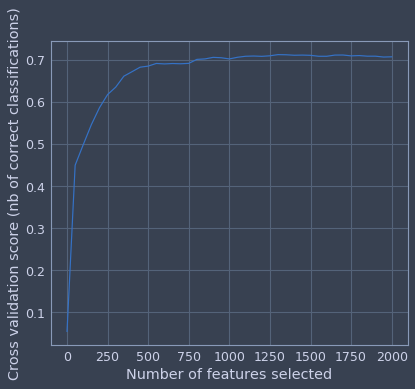

In [58]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(0, n+50, 50), rfecv.grid_scores_)
plt.show()

The dataframe with the selected features:

In [59]:
X_train.iloc[:, rfecv.support_].head()

,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,mammary_epithelial_cell_ChIP-seq_CTCF_ENCFF002CEB.bed,HepG2_ChIP-seq_CTCF_ENCFF002CDZ.bed,H1-hESC_ChIP-seq_H3K4me3_ENCFF001SVC.bed,H1-hESC_ChIP-seq_H3K4me1_ENCFF001SVA.bed,H1-hESC_ChIP-seq_H3K36me3_ENCFF001SUZ.bed,H1-hESC_ChIP-seq_H3K4me2_ENCFF001SVB.bed,...,Liver_H3K27ac_ctrl_006_hg19.bed,Liver_H3K4me1_ctrl_unknown_hg19.bed,pancreas_juvenile_H3K4me3.bed,pancreas_adult_H3K4me3.bed,pancreas_adult_H3K27ac.bed,Hepatocyte_PPARA_ctrl_2hr.bed,Hepatocyte_PPARA_GW7647_24hr.bed,islet_pooled_H3K4me1_final.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak
1804,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8603,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,1,1,1
9643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5414,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9989,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Save training and testing datframes only consisting of the features we have selected
rfecv_Xtraindf = X_train.iloc[:, rfecv.support_]
rfecv_Xtestdf = X_test.iloc[:, rfecv.support_]

# Write the created dataset to a file so we can test model performance later
write_to_S3(rfecv_Xtraindf, "rfecv/X_train.csv")
write_to_S3(y_train, "rfecv/y_train.csv")
write_to_S3(rfecv_Xtestdf, "rfecv/X_test.csv")
write_to_S3(y_test, "rfecv/y_test.csv")